In [0]:
# Initialisation du notebook en important les différents modules nécessaires
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict

# Initialisation du client PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Importation des modules Python nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn import neighbors, metrics,preprocessing,model_selection,linear_model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Ce notebook a été créé dans le but de réaliser un projet de parcours Data Scientist, à savoir réaliser une application innovante dans le domaine de l'alimentation. Projet réparti en deux notebooks différents, cette deuxième partie aura pour but l'analyse et la complétion du fichier de données créé précédemment, et de définir véritablement l'application proposée à l'agence "Santé Publique France".

Pour rappel, le fichier créé est une partie nettoyée de labase de données Open Food Facts contenant tous les produits français et des informations les concernant.

# Sommaire
1. Analyse des corrélations par ANOVA

  A. Nettoyage des informations nutritionnelles et étude de la répartition

  B. Calcul des ANOVAs
  
2. Réduction des dimensions par PCA

  A. Préparation des données nécessaires pour la suite de l'analyse
  
  B. Choix du nombre de dimensions
  
  C. Calcul du PCA
  
3. Remplissage des données manquantes par k-NN
    
  A. Choix du k-NN utilisé
  
  B. Application de ce k-NN sur la variable choisie

In [36]:
#Importation des données dans le notebook, à partir du Google Drive
link1="https://drive.google.com/open?id=1Df5GOBqtDEa5sALWgmrF3XC14xquLZvL" 
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fichier_nettoye_projet3.csv')  
data = pd.read_csv('fichier_nettoye_projet3.csv',sep='\t')
print ("Data importées")

Data importées


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Analyse des corrélations par ANOVA

<h3>A. Nettoyage des informations nutritionnelles et étude de la répartition </h3>

Maintenant que nous avons nettoyé les données et obtenu un fichier plus rapide à parcourir car ne contenant que les variables et données d'intérêt, nous allons donc étudier les différentes corrélations possibles entre les variables dont nous disposons et le nutri-grade. En effet, nous savons déjà que le nutri-score et le nutri-grade représentent la même valeur, sauf que la première est une variable numérique et la deuxième est une variable catégorielle, et nous souhaitons faire une ANOVA.

Tout d'abord, nous sélectionnons nos données : en effet, nous avons vu précédemment que les informations nutritionnelles contiennent des valeurs clairement aberrantes (par exemple plus de 100g de protéines pour 100g de produits). Nous retirons donc les produits aux valeurs clairement aberrantes, car il serait trop aléatoire de les recalculer, et ces valeurs sont mathématiquement impossibles. Cela nous retire tout de même près de 200000 valeurs, mais considérer ces valeurs nous donnerait des statistiques non représentatives de la réalité. 

Pour l'énergie, nous n'avons pas ce même genre de repère et ne pouvons que soupçonner les valeurs aberrantes en plaçant les limites maximales à la limite des valeurs hautes "proches" de valeurs semblantes plus normales. Pour les autres informations nutritionnelles, il y a de nombreuses valeurs hors du boxplot : nous savons cependant qu'il y a tout type de produits dans notre base de données. Par exemple, nous pourrions avoir du sel de table (donc "sel_100g"=100) et autres produits aux valeurs semblant aberrantes de base, mais explicables. Nous considérons donc que, si les valeurs de chaque information nutritionnelle est entre 0 et 100g, nous conservons ces valeurs en l'état. Les éléments les plus présents dans les produits sont les carbohydrates (et les sucres compris dans cette catégorie) et les lipides.

Nous étudions ensuite chacune des variables en fonction du nutri-grade. Déjà, nous pouvons voir que les valeurs hors boxplot sont présentes pour tous les grades possibles, même si cela semble être moins important pour certaines (grade "e" de la variable "sucres" par exemple), l'exception étant bel et bien les carbohydrates qui ne semblent en contenir que très peu. La logique voudrait également que plus le grade est haut, plus les valeurs sont hautes, ou inversement selon l'information nutritionnelle. Cependant, à cause de la variabilité des valeurs, ceci est essentiellement visible pour les graisses (variables "fat" et "saturated_fat"), ce qui signifique que ces variables ont sûrement une forte influence sur le grade, mais que c'est la combinaison de plusieurs variables qui expliquera les valeurs de nutri-grades.


Nombre de produits avant suppression des informations nutritionnelles aberrantes :  531895
Nombre de produits après suppression des informations nutritionnelles aberrantes :  322417

Graphiques d'analyse univariée


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


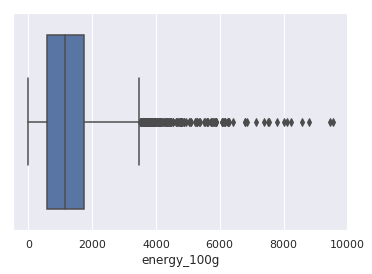

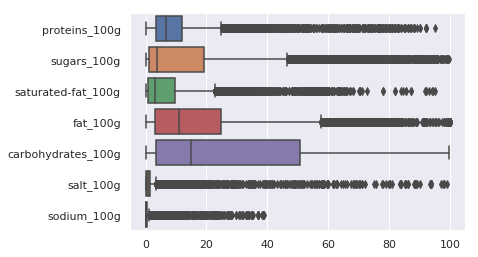


Graphiques d'analyse multivariée


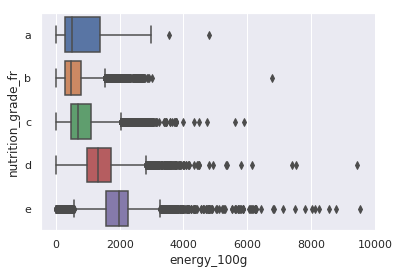

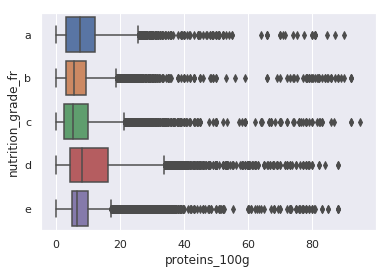

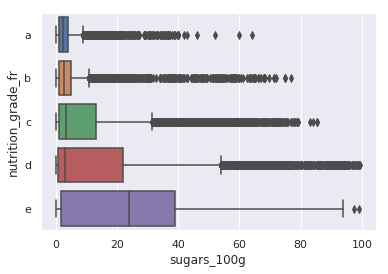

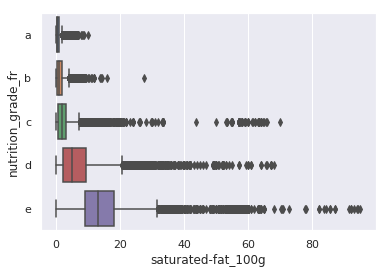

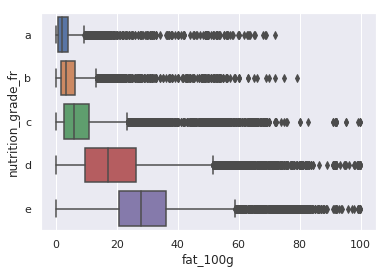

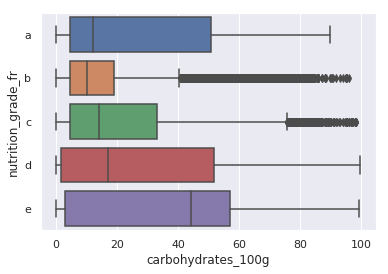

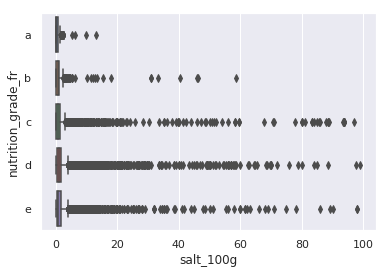

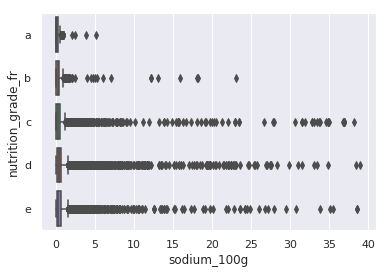

In [37]:
print ("Nombre de produits avant suppression des informations nutritionnelles aberrantes : ",len(data))
masque=(data["energy_100g"]<10000)&(data["energy_100g"]>0)&(data["proteins_100g"]<100)&(data["proteins_100g"]>0)&(data["sugars_100g"]<100)&(data["sugars_100g"]>0)&(data["saturated-fat_100g"]<100)&(data["saturated-fat_100g"]>0)&(data["fat_100g"]<100)&(data["fat_100g"]>0)&(data["carbohydrates_100g"]<100)&(data["carbohydrates_100g"]>0)&(data["salt_100g"]<100)&(data["salt_100g"]>0)&(data["sodium_100g"]<100)&(data["sodium_100g"]>0)
datanutrinettoyees=data[masque]
print ("Nombre de produits après suppression des informations nutritionnelles aberrantes : ",len(datanutrinettoyees))
dataanova=datanutrinettoyees[["energy_100g","proteins_100g","sugars_100g","saturated-fat_100g","fat_100g","carbohydrates_100g","salt_100g","sodium_100g","nutrition_grade_fr"]]
dataanova.dropna(how="any", inplace=True)

print ("\nGraphiques d'analyse univariée")

sns.set()
sns.boxplot(x=dataanova["energy_100g"],orient="h")
plt.show()

sns.set()
sns.boxplot(data=dataanova[["proteins_100g","sugars_100g","saturated-fat_100g","fat_100g","carbohydrates_100g","salt_100g","sodium_100g","nutrition_grade_fr"]],orient="h")
plt.show()

print ("\nGraphiques d'analyse multivariée")

sns.set()
sns.boxplot(data=dataanova,x="energy_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

sns.set()
sns.boxplot(data=dataanova,x="proteins_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

sns.set()
sns.boxplot(data=dataanova,x="sugars_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

sns.set()
sns.boxplot(data=dataanova,x="saturated-fat_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

sns.set()
sns.boxplot(data=dataanova,x="fat_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

sns.set()
sns.boxplot(data=dataanova,x="carbohydrates_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

sns.set()
sns.boxplot(data=dataanova,x="salt_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

sns.set()
sns.boxplot(data=dataanova,x="sodium_100g",y="nutrition_grade_fr",order=["a","b","c","d","e"])
plt.show()

<h3>B. Calcul des ANOVAs</h3>

Malgré les valeurs hors boxplot observées dans la partie A, nous pouvons voir, grâce aux différents calculs d'ANOVA, que toutes les variables d'informations nutritionnelles sont corrélées avec le nutri-grade, grâce à des p-values toutes inférieures à 0,05, valeur généralement considérée comme référence pour confirmer ou rejeter la corrélation. Nous conservons donc bel et bien tous les produits aux valeurs d'informations nutritionnelles compris entre 0 et 100.
Nous considérons donc tout aussi logiquement que ces informations nutritionnelles sont corrélées avec le nutri-score, car le nutri-grade est obtenu par des intervalles de nutri-score. 

In [38]:
print ("Calcul des différents ANOVA possibles pour le nutri-grade :")
grades=dataanova.groupby("nutrition_grade_fr").groups
for i in (dataanova.columns):
  if (i=="nutrition_grade_fr"):
    pass
  else:
    a=dataanova[i][grades["a"]]
    b=dataanova[i][grades["b"]]
    c=dataanova[i][grades["c"]]
    d=dataanova[i][grades["d"]]
    e=dataanova[i][grades["e"]]
    print ("p-value du nutri-grade et de la variable '",i,"' : ", st.f_oneway(a,b,c,d,e).pvalue )

Calcul des différents ANOVA possibles pour le nutri-grade :
p-value du nutri-grade et de la variable ' energy_100g ' :  0.0
p-value du nutri-grade et de la variable ' proteins_100g ' :  0.0
p-value du nutri-grade et de la variable ' sugars_100g ' :  0.0
p-value du nutri-grade et de la variable ' saturated-fat_100g ' :  0.0
p-value du nutri-grade et de la variable ' fat_100g ' :  0.0
p-value du nutri-grade et de la variable ' carbohydrates_100g ' :  0.0
p-value du nutri-grade et de la variable ' salt_100g ' :  0.0
p-value du nutri-grade et de la variable ' sodium_100g ' :  0.0


#2. Réduction des dimensions par PCA


<h3>A. Préparation des données nécessaires pour la suite de l'analyse</h3>

Pour commencer, nous pouvons d'ores et déjà anticiper les quatre différents sets de données dont nous aurons besoin pour la suite. Ainsi, nous devrons avoir :
* un set contenant les données complétées d'informations nutritionnelles et du nutri-score (datasccomp).
* un set contenant les données manquantes du nutri-score avec les informations nutritionnelles complètes (datascmanq).
* un set contenant les données complétées d'informations nutritionnelles et du nutri-grade (datagrcomp).
* un set contenant les données manquantes du nutri-grade avec les informations nutritionnelles complètes (datagrmanq).

En effet, nous devons compléter les informations du nutri-score ou du nutri-grade selon un algorithme de machine learning, qui sera ici un k-NN, selon le score obtenu dans chacun des deux cas. Or, pour plus de rapidité et diminuer au maximum de possibles biais, il serait intéressant de diminuer le nombre de dimensions utilisées pour compléter le score/grade. Pour cela, nous utilisons donc une PCA, et les sets de données devront être les mêmes entre la PCA et le k-NN.

Pour faire une PCA, toutes les variables à analyser doivent être sous format numérique, ce qui n'est pas le cas du nutri-grade (allant ici de A à E). Nous commençons donc par les modifier : ils vont maintenant de 1 à 5. 


In [39]:
# Création des 4 sets de données

masque=(datanutrinettoyees["energy_100g"].notna())&(datanutrinettoyees["proteins_100g"].notna())&(datanutrinettoyees["sugars_100g"].notna())&(datanutrinettoyees["saturated-fat_100g"].notna())&(datanutrinettoyees["fat_100g"].notna())&(datanutrinettoyees["carbohydrates_100g"].notna())&(datanutrinettoyees["salt_100g"].notna())&(datanutrinettoyees["sodium_100g"].notna())&(datanutrinettoyees['nutrition_grade_fr'].notna())
datagrcomp=datanutrinettoyees[masque]
dataanovagrinfo=datagrcomp[['energy_100g', 'proteins_100g', 'sugars_100g','saturated-fat_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g','sodium_100g']]

masque=(datanutrinettoyees["energy_100g"].notna())&(datanutrinettoyees["proteins_100g"].notna())&(datanutrinettoyees["sugars_100g"].notna())&(datanutrinettoyees["saturated-fat_100g"].notna())&(datanutrinettoyees["fat_100g"].notna())&(datanutrinettoyees["carbohydrates_100g"].notna())&(datanutrinettoyees["salt_100g"].notna())&(datanutrinettoyees["sodium_100g"].notna())&(datanutrinettoyees['nutrition-score-fr_100g'].notna())
datasccomp=datanutrinettoyees[masque]
dataanovascinfo=datasccomp[['energy_100g', 'proteins_100g', 'sugars_100g','saturated-fat_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g','sodium_100g']]


masque=(datanutrinettoyees["energy_100g"].notna())&(datanutrinettoyees["proteins_100g"].notna())&(datanutrinettoyees["sugars_100g"].notna())&(datanutrinettoyees["saturated-fat_100g"].notna())&(datanutrinettoyees["fat_100g"].notna())&(datanutrinettoyees["carbohydrates_100g"].notna())&(datanutrinettoyees["salt_100g"].notna())&(datanutrinettoyees["sodium_100g"].notna())&(datanutrinettoyees['nutrition_grade_fr'].isna())
datagrmanq=datanutrinettoyees[masque]
del datagrmanq["nutrition_grade_fr"]
datagrmanqinfo=datagrmanq[['energy_100g', 'proteins_100g', 'sugars_100g','saturated-fat_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g','sodium_100g']]

masque=(datanutrinettoyees["energy_100g"].notna())&(datanutrinettoyees["proteins_100g"].notna())&(datanutrinettoyees["sugars_100g"].notna())&(datanutrinettoyees["saturated-fat_100g"].notna())&(datanutrinettoyees["fat_100g"].notna())&(datanutrinettoyees["carbohydrates_100g"].notna())&(datanutrinettoyees["salt_100g"].notna())&(datanutrinettoyees["sodium_100g"].notna())&(datanutrinettoyees['nutrition-score-fr_100g'].isna())
datascmanq=datanutrinettoyees[masque]
del datascmanq["nutrition-score-fr_100g"]
datascmanqinfo=datascmanq[['energy_100g', 'proteins_100g', 'sugars_100g','saturated-fat_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g','sodium_100g']]

#Transformation de la variable "nutrition_grade" en numérique

def transformvariable(liste):
  variable=[]
  grade_numb=["a","b","c","d","e"]
  for i,e in enumerate(liste):
    if (e in grade_numb):
      variable.append((grade_numb.index(e))+1)
    else:
      print (i)
  return variable

var=transformvariable(datagrcomp['nutrition_grade_fr'])
datagrcomp["nutrition_grade_fr_int"]=var

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  <h3>B. Choix du nombre de dimensions</h3>

Nous ne savons pas le nombre de dimensions idéales pour effectuer notre PCA, la seule connaissance que nous avons est que nous avons actuellement 8 dimensions. Nous allons donc calculer la variance expliquée dimension par dimension : lorsque le cumul de cette variance dépasse les 80%, nous considérerons avoir atteint le bon nombre de dimensions.

Dans notre cas, nous pouvons voir que nous atteignons une variance expliquée cumulée de 0.80946577 à partir de la 3ème dimension : c'est donc ces 3 dimensions que nous gardons pour notre calcul de PCA. Nous pouvons également voir que faire ce calcul de variance expliquée sur le nutri-grade ou le nutri-score donne exactement les mêmes valeurs : nous pouvons donc partir sur l'hypothèse que les sets de données pour le nutri-score et le nutri-grade sont pareillement composées (en plus de faire la même taille) et ne faire la PCA que pour l'un des deux, à savoir le nutri-grade.

In [40]:
X = dataanovagrinfo.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = PCA(n_components=None)
pca.fit(X_scaled)
print ("Variance expliquée sur les données complètes de nutri-grade : ",np.cumsum(pca.explained_variance_ratio_))

X = dataanovascinfo.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

pca = PCA(n_components=None)
pca.fit(X_scaled)
print ("Variance expliquée sur les données complètes de nutri-score : ",np.cumsum(pca.explained_variance_ratio_))

print ("Nombre de produits ayant un nutri-score : ",len(dataanovascinfo))
print ("Nombre de produits ayant un nutri-grade : ",len(dataanovagrinfo))

Variance expliquée sur les données complètes de nutri-grade :  [0.32188976 0.60862709 0.80946577 0.91331614 0.96338146 0.99450886
 0.99999993 1.        ]
Variance expliquée sur les données complètes de nutri-score :  [0.32188976 0.60862709 0.80946577 0.91331614 0.96338146 0.99450886
 0.99999993 1.        ]
Nombre de produits ayant un nutri-score :  135205
Nombre de produits ayant un nutri-grade :  135205


  <h3>C. Calcul du PCA</h3>
  
Maintenant que nous savons sur combien de dimensions la PCA doit être faite, nous la calculons donc pour obtenir les 3 PCs nécessaires à nos futurs k-NN.

Nous voyons également des "couples" de variables semblant avoir les mêmes influences sur les PCs :
* les différents lipides : "fat" et "saturated-fat"
* le sel : "salt" et "sodium"
* les glucides : "carbohydrates" et "sugars"
Ces couples confirment bien les observations précédentes, et respectent la logique des informations nutritionnelles, vu qu'il s'agit de regroupements faites dans celles-ci.


Les différents PC possibles :
      energy_100g  proteins_100g  sugars_100g  saturated-fat_100g  fat_100g
PC-1    -0.565499       0.019583    -0.335116           -0.449712 -0.465364
PC-2     0.151770       0.331577    -0.289268            0.272504  0.332032
PC-3     0.075298      -0.242821     0.433822           -0.200828 -0.210288
      carbohydrates_100g  salt_100g  sodium_100g
PC-1           -0.306581   0.165419     0.165422
PC-2           -0.302923   0.503527     0.503529
PC-3            0.484385   0.462595     0.462591


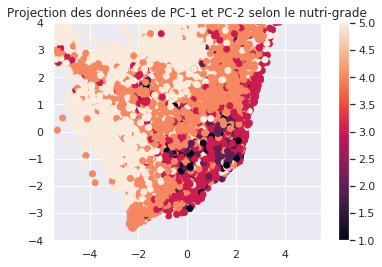

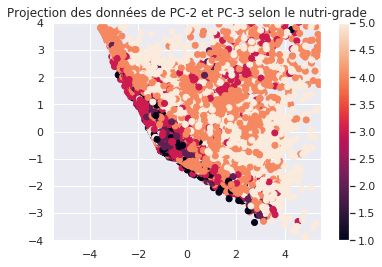

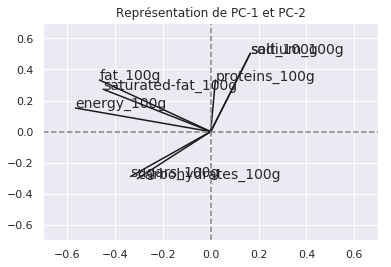

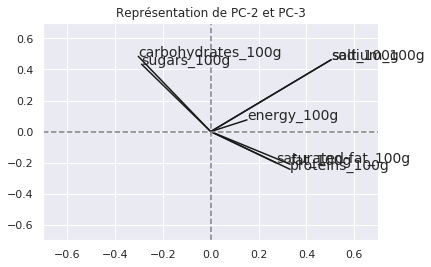

In [41]:
pca_final=PCA(n_components=3)
pca_final.fit_transform(X_scaled)
pca_results=pd.DataFrame(pca_final.components_,columns=dataanovagrinfo.columns,index=["PC-1","PC-2","PC-3"])
print ("\nLes différents PC possibles :" )
print (pca_results.iloc[:,:5])
print (pca_results.iloc[:,5:])

X_projected = pca_final.transform(X_scaled) # Projection de notre X sur les PCs

# Graphiques représentant chaque observation sur PC-1 et PC-2, puis PC-2 et OC-3
sns.set()
plt.scatter(X_projected[:, 0], X_projected[:, 1],c=datagrcomp.get('nutrition_grade_fr_int'))

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.title("Projection des données de PC-1 et PC-2 selon le nutri-grade")
plt.colorbar()
plt.show()

sns.set()
plt.scatter(X_projected[:, 1], X_projected[:, 2],c=datagrcomp.get('nutrition_grade_fr_int'))

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.title("Projection des données de PC-2 et PC-3 selon le nutri-grade")
plt.colorbar()
plt.show()

# Graphiques représentant la variance expliquée de chaque variable entre PC-1 et PC-2, puis entre PC-2 et PC-3

pcs = pca_final.components_
sns.set()
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, dataanovagrinfo.columns[i], fontsize='14')

plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--') # Afficher une ligne horizontale y=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--') # Afficher une ligne verticale x=0
plt.title("Représentation de PC-1 et PC-2")
plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
plt.show()

sns.set()
for i, (x, y) in enumerate(zip(pcs[1, :], pcs[2, :])):
    plt.plot([0, x], [0, y], color='k')
    plt.text(x, y, dataanovagrinfo.columns[i], fontsize='14')
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--') # Afficher une ligne horizontale y=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--') # Afficher une ligne verticale x=0
plt.title("Représentation de PC-2 et PC-3")
plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
plt.show()

#3. Remplissage des données manquantes par k-NN

<h3>A. Choix du k-NN utilisé</h3>

La dernière chose à faire sur ces données serait de compléter le nutri-grade/nutri-score pour avoir les valeurs pour tous les produits : seule l'une des variables est importante vu qu'elles sont identiques, à l'exception que la première est catégorielle et l'autre numérique. Pour cela, deux solutions sont possibles, en prenant le score le plus haut entre les deux choix :

*   Utiliser un k-NN de régression pour compléter le nutri-score : les meilleurs résultats sont obtenus en utilisant les 14 plus proches voisins (score=0,85)
*   Utiliser un k-NN de classification pour compléter le nutri-grade : les meilleurs résultats sont obtenus en utilisant les 5 plus proches voisins (score=0,74)

Le plus haut score étant obtenu avec le k-NN de régression, nous utiliserons donc ce k-NN pour compléter le nutri-score. 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: 0.850429953624352  avec n_neighbors =  [14]


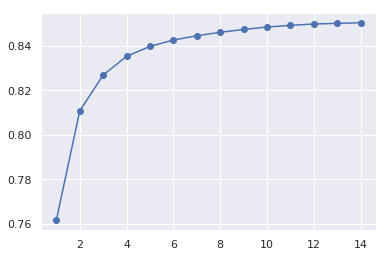

In [42]:
# k-NN de régression

y = datasccomp.as_matrix([datasccomp.columns[-1]])
y = y.flatten()

score = []
for i in range(1, 15):
    knnreg = neighbors.KNeighborsRegressor(n_neighbors=i)
    score.append(np.mean(model_selection.cross_val_score(knnreg, X_projected, y, cv=5)))
    
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",max(score)," avec n_neighbors = ",[i+1 for i, j in enumerate(score) if j == max(score)])
plt.plot(range(1,15), score, 'o-')
plt.show()

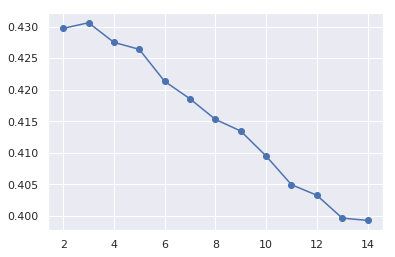

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: 0.4306053770200806  avec n_neighbors =  [3]


In [43]:
#k-NN de classification
knndata=X_projected
knntarget= datagrcomp[datagrcomp.columns[-2]]

xtrain, xtest, ytrain, ytest = train_test_split(knndata, knntarget, train_size=0.8)

score = []
for k in range(2,15):
    knnclas = neighbors.KNeighborsClassifier(k)
    score.append(knnclas.fit(xtrain, ytrain).score(xtest, ytest))
plt.plot(range(2,15), score, 'o-')
plt.show()


print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",max(score)," avec n_neighbors = ",[i+2 for i, j in enumerate(score) if j == max(score)])

<h3>  B. Application de ce k-NN sur la variable choisie</h3>

Maintenant que nous avons sélectionné le bon k-NN, nous pouvons donc l'appliquer sur les valeurs manquantes de nutri-score afin de le calculer, et ce à partir des informations nutritionnelles. Ainsi, il est important d'avoir accès à toutes les informations nutritionnelles.

Lorsque le calcul est effectué, nous rassemblons ensuite le set de données nouvellement calculées et le set de données déjà complètes en un seul et unique fichier, qui sera celui utilisé pour la future application.

In [44]:
knnreg= neighbors.KNeighborsRegressor(n_neighbors=14)
knnreg.fit(X_projected, y)

Xmanq=pca_final.transform(datascmanqinfo)
grade_predict=knnreg.predict(Xmanq)

datascmanq["nutrition-score-fr_100g"]=grade_predict

datafinal=pd.concat([datasccomp,datascmanq])

print (datafinal.head())

    Unnamed: 0           code  ... nutrition_grade_fr  nutrition-score-fr_100g
8           10  0000000000949  ...                  b                      1.0
14          17  0000000001281  ...                  d                     14.0
26          31  0000000002257  ...                  b                      1.0
44          51  0000000005005  ...                  d                     14.0
46          53  0000000005166  ...                  c                      4.0

[5 rows x 16 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Conclusion

Au final, après tri de la base de données Open Food Fact fournie par l'agence "Santé publique France", nous avons réussi à en récupérer 322417 produits français possédant toutes les informations nutritionnelles et un nutri-score cohérents. Notre application utilisera donc ces produits afin de proposer aux consommateurs français les produits les plus intéressants en termes de nutri-score pour des considérations générales, mais aussi par information nutritionnelle si cela est souhaité. La liste de résultats donnée pourra également être triée selon les marques, mais également les catégories possibles de produits, au cas où un élément recherché soit dans plusieurs d'entre elles (par exemple, des légumes peuvent se trouver en conserve ou en surgelé, ou un produit préparé peut être en épicerie ou en frais). Notre application sera donc en mesure d'aider simplement les utilisateurs à faire leur choix parmi la grande diversité de produits disponibles dans les rayons des supermarchés et autres magasins alimentaires. 

In [45]:
print (datafinal.columns)
print ("Description générale des produits")
print (datafinal[['code', 'product_name']].describe(include="all"))
print (datafinal[['brands','categories','main_category_en']].describe(include="all"))
print ("Informations nutritionnelles")
print (datafinal[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g']].describe(include="all"))
print (datafinal[['salt_100g', 'sodium_100g', 'sugars_100g','carbohydrates_100g']].describe(include="all"))
print (datafinal[['nutrition-score-fr_100g']].describe(include="all"))

Index(['Unnamed: 0', 'code', 'product_name', 'energy_100g', 'proteins_100g',
       'sugars_100g', 'saturated-fat_100g', 'fat_100g', 'carbohydrates_100g',
       'salt_100g', 'sodium_100g', 'brands', 'categories', 'main_category_en',
       'nutrition_grade_fr', 'nutrition-score-fr_100g'],
      dtype='object')
Description générale des produits
                 code product_name
count          322417       322390
unique         322393       237394
top     3428420053203        Comté
freq                2          329
        brands categories main_category_en
count   176435     139066           139025
unique   35656      29259             1868
top     Auchan   Boissons           Snacks
freq      5035       1081            27991
Informations nutritionnelles
         energy_100g      fat_100g  saturated-fat_100g  proteins_100g
count  322417.000000  3.224170e+05        3.224170e+05   3.224170e+05
mean     1251.051483  1.514686e+01        6.130168e+00   9.581387e+00
std       726.411103  1.

In [46]:
# Sauvegarde fichier final
datafinal.to_csv('fichier_final.csv', sep = '\t')
print ("Fichier créé")
uploaded = drive.CreateFile({'title': 'fichier_final.csv'})
uploaded.SetContentFile('fichier_final.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Fichier créé
Uploaded file with ID 1f_dvXWFm5C_aeStvyEjJSEZgtmIxh-D3
